## Loading modules

In [ ]:
import base64
import numpy as np
import cv2
import os
import re
import string
import time
from tqdm import tqdm
from itertools import groupby
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F

In [ ]:
!nvidia-smi

Sat Oct 16 19:32:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.68       Driver Version: 471.68       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    20W / 350W |    799MiB / 12288MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Uncommnet for mounting google drive if work proccess in google colaboratory
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define folder for experiments
data_folder = 'E://pyProject/MinerKiller/captcha_base/captcha_solver/'
font_path = os.path.join(data_folder, 'fonts', 'lexend')

## Captcha generator

In [ ]:
# Load all selected fonts in range of text sizes from 25 to 26
fonts = {}
font_names = list(os.listdir(font_path))
text_size_start = 25
text_size_end = 27
font_sizes = list(range(text_size_start, text_size_end))
for fontname in font_names:
    for i in font_sizes:
        font_discriptor = f'{fontname}_{i}'
        font = ImageFont.truetype(os.path.join(font_path, fontname), i)
        fonts[font_discriptor] = font

print(len(fonts))

26


Lexend-Black.ttf_25


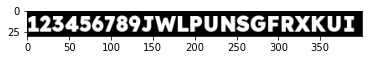

Lexend-Black.ttf_26


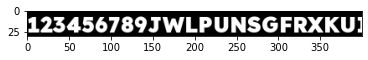

Lexend-Bold.ttf_25


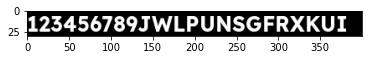

Lexend-Bold.ttf_26


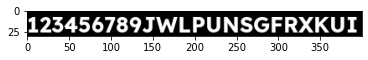

Lexend-ExtraBold.ttf_25


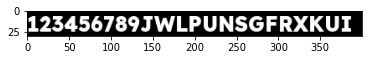

Lexend-ExtraBold.ttf_26


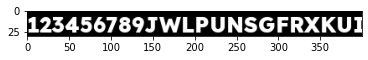

Lexend-SemiBold.ttf_25


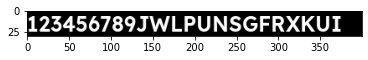

Lexend-SemiBold.ttf_26


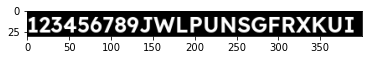

LexendDeca-Black.ttf_25


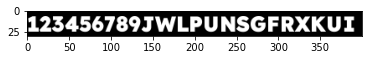

LexendDeca-Black.ttf_26


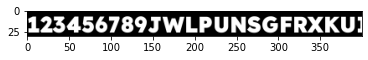

LexendDeca-Bold.ttf_25


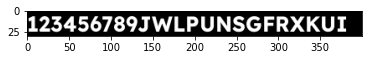

LexendDeca-Bold.ttf_26


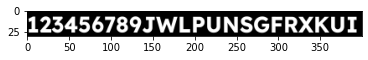

LexendDeca-ExtraBold.ttf_25


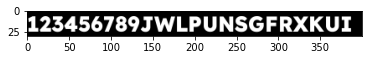

LexendDeca-ExtraBold.ttf_26


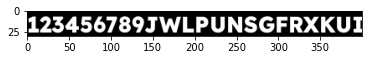

LexendDeca-Medium.ttf_25


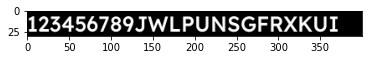

LexendDeca-Medium.ttf_26


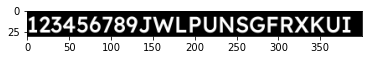

LexendDeca-Regular.ttf_25


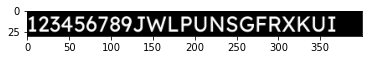

LexendDeca-Regular.ttf_26


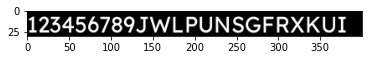

LexendDeca-SemiBold.ttf_25


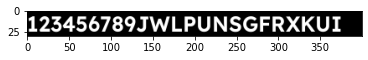

LexendDeca-SemiBold.ttf_26


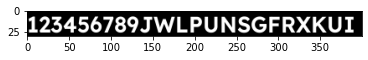

NowAlt-Bold.otf_25


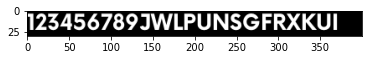

NowAlt-Bold.otf_26


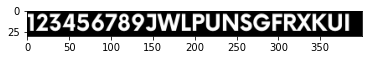

PassionOne-Bold.ttf_25


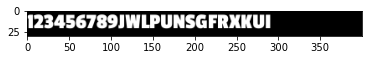

PassionOne-Bold.ttf_26


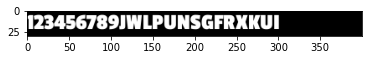

PassionOne-Regular.ttf_25


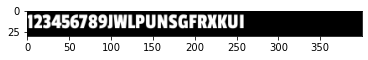

PassionOne-Regular.ttf_26


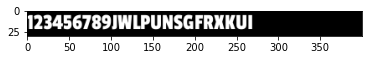

In [ ]:
# Take a look at fonts representation for defining more suitable for problem letters
test_phrase = '123456789JWLPUNSGFRXKUI'
for font in fonts.keys():
    print(font)
    curr_font = fonts[font]
    
    new_arr = np.full((30, 400,3), 0, dtype=np.uint8)
    new_img = Image.fromarray(new_arr)
    draw = ImageDraw.Draw(new_img)
    draw.text((0, 0), test_phrase.upper(), font=curr_font)
    
    plt.imshow(new_img)
    plt.show()

In [ ]:
# Define fonts for problem letters
fonts_for_s = ['PassionOne-Bold.ttf_25',
              'PassionOne-Bold.ttf_26',
              'PassionOne-Regular.ttf_25',
              'PassionOne-Regular.ttf_26']

fonts_for_j = ['Lexend-Black.ttf_25',
               'Lexend-Black.ttf_26',
               'Lexend-Bold.ttf_25',
               'Lexend-Bold.ttf_26',
               'Lexend-ExtraBold.ttf_25',
               'Lexend-ExtraBold.ttf_26',
               'Lexend-SemiBold.ttf_25',
               'Lexend-SemiBold.ttf_26',
               'LexendDeca-Black.ttf_25',
               'LexendDeca-Black.ttf_26',
               'LexendDeca-Bold.ttf_25',
               'LexendDeca-Bold.ttf_26',
               'LexendDeca-Medium.ttf_25',
               'LexendDeca-Medium.ttf_26',
               'LexendDeca-SemiBold.ttf_25',
               'LexendDeca-SemiBold.ttf_26']

Functions for captcha generator

In [ ]:
def generate_point_sets(shape, min_w, max_w):
    ''' Points sets for perspective transform '''

    h, w = shape[:2]
    bottom_w = np.random.randint(0, min_w)
    top_w = w - np.random.randint(0, w - max_w)
    set_number = np.random.randint(0, 4)

    startpoints_sets = [[[bottom_w,0], [top_w,0], [0,h], [w,h]], # top
                        [[0,0], [w,0], [bottom_w,h], [top_w,h]], # bottom
                        [[0,0], [max_w,0], [min_w,h], [w,h]], # diag_1 (top left -> bottom right)
                        [[min_w,0], [w,0], [0,h], [max_w,h]]] # diag_2 (top right -> bottom left)

    if set_number < 2: # Trapezium transform
        final_w = top_w - bottom_w
        endpoints_set = [[0,0], [final_w,0], [0,h], [final_w,h]]
    else: # Diagonal transfrom
        final_w = max_w - min_w
        endpoints_set = [[0,0], [final_w,0], [0,h], [final_w,h]]

    return np.array(startpoints_sets[set_number], dtype=np.float32), np.array(endpoints_set, dtype=np.float32)


def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode='constant', cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode='constant', cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)


def generate_bw_letter(letter_shape, letter):
    
    symbol = letter.upper()
    
    # Create empty image
    new_arr = np.full(letter_shape, 0, dtype=np.uint8)
    new_img = Image.fromarray(new_arr)
    draw = ImageDraw.Draw(new_img)

    # Define font and font size
    fontsize = np.random.choice(font_sizes)
    y = np.random.randint(0, letter_shape[0]-fontsize)
    fontname = np.random.choice(font_names)
    
    if symbol in ['S', 'G', 'F']:
        font_discriptor = np.random.choice(fonts_for_s)
    elif symbol in ['J', 'I']:
        font_discriptor = np.random.choice(fonts_for_j)
    else:
        font_discriptor = f'{fontname}_{fontsize}'
    font = fonts[font_discriptor]

    # Place letter on empty image
    draw.text((0, y), symbol, font=font)
    letter_img = np.array(new_img, dtype=np.uint8)
    gray_img = cv2.cvtColor(letter_img, cv2.COLOR_BGR2GRAY)
    
    # Crop letter from image by its horizontal boundaries
    white_ind = np.where(gray_img > 1)[1]
    min_w = np.min(white_ind)
    max_w =  np.max(white_ind)
    if max_w == (gray_img.shape[1] - 1):
        gray_img = gray_img[:, min_w:max_w]
    else:
        gray_img = gray_img[:, min_w:max_w+1]
    
    return gray_img


def perspective_transform(gray_img, add_w=10):
    
    # Lengthen image with blank lines at left and right boundaries
    # to prevent letter clipping after transformation
    h, w = gray_img.shape[:2]
    left = np.full((h, add_w), 0, dtype=np.uint8)
    right = np.full((h, add_w), 0, dtype=np.uint8)
    gray_img = np.concatenate((left, gray_img, right), axis=1)
    w += 2 * add_w
    min_w = add_w
    max_w = w - add_w

    startpoints_set, endpoints_set = generate_point_sets([h, w], min_w, max_w, coef_w)
    M = cv2.getPerspectiveTransform(startpoints_set, endpoints_set)
    gray_img = cv2.warpPerspective(gray_img, M, (int(endpoints_set[1][0]), h))

    # Crop letter from image by its horizontal boundaries
    white_ind = np.where(gray_img > 1)[1]
    min_w = np.min(white_ind)
    max_w =  np.max(white_ind)
    if max_w == (gray_img.shape[1] - 1):
        gray_img = gray_img[:, min_w:max_w]
    else:
        gray_img = gray_img[:, min_w:max_w+1]

    return gray_img

    
def affine_transform(gray_img, add_w=10):
    
    # Lengthen image with blank lines at left and right boundaries
    # to prevent letter clipping after transformation
    h, w = gray_img.shape[:2]
    left = np.full((h, add_w), 0, dtype=np.uint8)
    right = np.full((h, add_w), 0, dtype=np.uint8)
    gray_img = np.concatenate((left, gray_img, right), axis=1)

    center = (gray_img.shape[1]//2, gray_img.shape[0]//2)
    angle = np.random.randint(-30, 30)
    scale = np.random.randint(100, 140) / 100
    rot_mat = cv2.getRotationMatrix2D(center, angle, scale)
    gray_img = cv2.warpAffine(gray_img, rot_mat, (gray_img.shape[1], gray_img.shape[0]))
    
    # Crop letter from image by its horizontal boundaries
    white_ind = np.where(gray_img > 1)[1]
    min_w = np.min(white_ind)
    max_w =  np.max(white_ind)
    if max_w == (gray_img.shape[1] - 1):
        gray_img = gray_img[:, min_w:max_w]
    else:
        gray_img = gray_img[:, min_w:max_w+1]
    
    return gray_img


def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()


def generate_captcha(phrase, sigma, alpha, shape, letter_shape, coef_w, add_w):

    final_img = np.full(shape[:2], 256, dtype=np.int32)
    intersection_limit = 41 # Limit for letters intersection on full image(if intersection is great it is hard to recognize letter)
    intersection_letter_limit = 10 # Limit of intersection for two individual letters

    while np.sum(np.where(final_img > 255)[0]) > intersection_limit:
        imgs = [] # Empty list for  letters images
        x_start = 0 # Start position of first letter

        for i in range(len(phrase)):

            # Transformations
            gray_img = generate_bw_letter(letter_shape, phrase[i])
            # show_img(gray_img)
            if np.random.rand() > 0.5:
                gray_img = affine_transform(gray_img, add_w)
                # show_img(gray_img)
                gray_img = perspective_transform(gray_img, add_w)
                # show_img(gray_img)
            else: 
                gray_img = perspective_transform(gray_img, add_w)
                # show_img(gray_img)
                gray_img = affine_transform(gray_img, add_w)
                # show_img(gray_img)
            
            gray_img = elastic_transform(gray_img[:,:,np.newaxis], alpha, sigma, random_state=None).squeeze()
            # show_img(gray_img)
            
            # Lengthen letter image to final size with black lines at left and right
            left_img_part = np.full((shape[0], max((1, x_start))), 0, dtype=np.uint8)
            right_border = (left_img_part.shape[1] + gray_img.shape[1])
            right_len = max((1, shape[1] - right_border))
            right_img_part = np.full((shape[0], right_len), 0, dtype=np.uint8)
            imgs.append(np.concatenate((left_img_part, gray_img, right_img_part), axis=1))

            # Define start posiztion of next letter
            x_start = right_border + np.random.randint(-5, 0)
            if i == (len(phrase)-2):
                x_start = min((x_start, shape[1] - letter_shape[1] - 10))

        # Fill black image with generated letters one by one with controlled intersection
        final_img = np.full(shape[:2], 0, dtype=np.int32)
        for img_number, img in enumerate(imgs):
            tmp_img = img
            # If intersection is greater then intersection_letter_limit shift letter to the right
            while np.sum(np.where((final_img + tmp_img) > 255)[0]) > intersection_letter_limit:
                tmp_img = np.concatenate((np.full((shape[0], 2), 0, dtype=np.uint8), tmp_img[:,:-2]), axis=1)
            final_img += tmp_img

    # Due to the fact that letters settled primarily at the left boundary, perform randon shift at all image length
    white_ind = np.where(final_img > 10)
    min_w, max_w = np.min(white_ind[1]), np.max(white_ind[1])
    min_h, max_h = np.min(white_ind[0]), np.max(white_ind[0])
    pandom_rotate = np.random.randint(shape[1] - max_w) if max_w != shape[1] else 0
    if pandom_rotate != 0:
        final_img = np.concatenate((np.full((shape[0], pandom_rotate), 0, dtype=np.uint8), final_img[:,:-pandom_rotate]), axis=1)
    
    # After adding letters images pixel values can be greater then 255, so perform slipping 
    final_img = np.clip(final_img, 0, 255).astype(np.uint8)
    # After transformations images can have a lot of blurred pixels with low intensity, so remove them
    final_img[final_img < 75] = 0 

    return final_img

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}


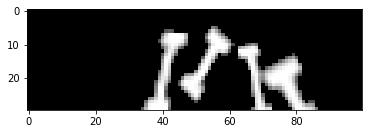

In [ ]:
# Captcha generator test
phrase = 'IIII'
# Set symbols for phrase creation
alphabet = string.ascii_uppercase + '0123456789'
ALPHABET_NP = np.array([*alphabet])
labels_dict = {key: value for value, key in enumerate(ALPHABET_NP)}
print(labels_dict)
invers_dict = {value: key for key, value in labels_dict.items()}
print(invers_dict)

# Set generator parameters
SIGMA = 4.5
ALPHA = 150
SHAPE = (30, 100, 3)
letter_shape = (30, 30, 3)
add_w = 10

captcha = generate_captcha(phrase, SIGMA, ALPHA, SHAPE, letter_shape, add_w)
plt.imshow(captcha, cmap='gray')
plt.show()

## Datasets

In [ ]:
def label_generator(alphabet_np, captcha_len=4):
    indices = np.random.choice(len(alphabet_np), captcha_len, replace=False)
    phrase = ''.join(alphabet_np[indices])
    
    return phrase


class TestDataset(Dataset):
    def __init__(self, images, labels, labels_dict):
        self.images = images
        self.labels = labels
        self.labels_dict = labels_dict

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        label_indices = [self.labels_dict[letter] for letter in label]
        label_indices = np.hstack(np.array(label_indices).reshape(len(label_indices), 1))

        image = np.expand_dims(image, axis=0)
        torch_img = torch.FloatTensor(image / 255)

        data = {'image': torch_img, 'label': label_indices}

        return data


class TrainDataset(Dataset):
    def __init__(self, dataset_len, labels_dict):
        self.dataset_len = dataset_len
        self.labels_dict = labels_dict
        # self.alphabet_np = alphabet_np

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
        label = label_generator(ALPHABET_NP)
        label_indices = [self.labels_dict[letter] for letter in label]
        label_indices = np.hstack(np.array(label_indices).reshape(len(label_indices), 1))

        image = generate_captcha(label, SIGMA, ALPHA, SHAPE, letter_shape, COEF_W, add_w)
        image = np.expand_dims(image, axis=0)
        torch_img = torch.FloatTensor(image / 255)

        data = {'image': torch_img, 'label': label_indices}

        return data

3.867032766342163


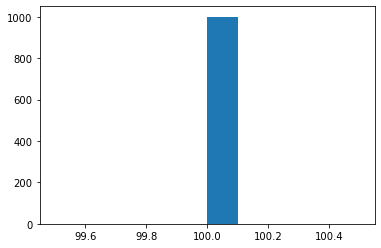

In [ ]:
# Validation dataset creation
test_images = []
test_labels = []
start_time = time.time()

for i in range(1000):
    indices = np.random.choice(len(ALPHABET_NP), 4, replace=False)
    phrase = ''.join(ALPHABET_NP[indices])
    test_labels.append(phrase)
    img = generate_captcha(phrase, SIGMA, ALPHA, SHAPE, letter_shape, COEF_W, add_w)
    test_images.append(img)

print(time.time() - start_time)
shapes = []
for test_img in test_images:
    shapes.append(test_img.shape[1])

plt.hist(shapes)
plt.show()

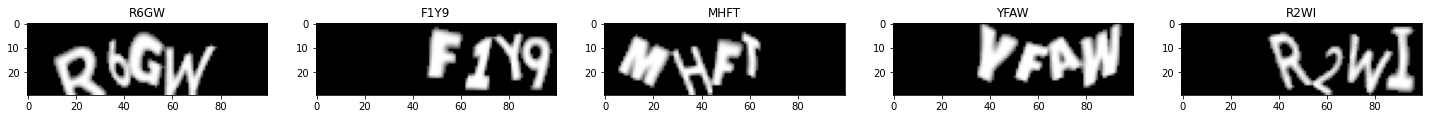

In [ ]:
# Take a look at some exapmles from validational dataset
indices = [0, 200, 250, 600, 899]
fig, ax = plt.subplots(1, len(indices), figsize=(25,5))
for i in range(len(indices)):
    ax[i].imshow(test_images[indices[i]], cmap='gray')
    ax[i].set_title(''.join(test_labels[indices[i]]))
plt.show()

In [ ]:
# Save dataset for experiments repeatability
np.savez(os.path.join(data_folder, 'test_data_5.npz'), images=test_images, labels=test_labels)

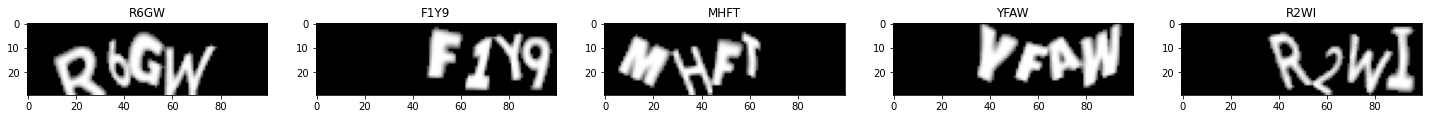

In [ ]:
# Donwload dataset and check that it is the same
test_data = np.load(os.path.join(data_folder, 'test_data_5.npz'))
test_images = test_data['images']
test_labels = test_data['labels']

indices = [0, 200, 250, 600, 899]
fig, ax = plt.subplots(1, len(indices), figsize=(25,5))
for i in range(len(indices)):
    ax[i].imshow(test_images[indices[i]], cmap='gray')
    ax[i].set_title(''.join(test_labels[indices[i]]))
plt.show()

In [ ]:
# Define training dataset parameters
BATCH_SIZE = 128
train_dataset_len = 5000

train_dataset = TrainDataset(train_dataset_len, labels_dict)
test_dataset = TestDataset(test_images, test_labels, labels_dict)

train_dataloader = DataLoader(train_dataset, BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)

In [ ]:
# Check datasets batch dimensions
test_data = next(iter(train_dataloader))
print(test_data['image'].shape)
print(test_data['label'].shape)

torch.Size([128, 1, 30, 100])
torch.Size([128, 4])


0.0 1.0


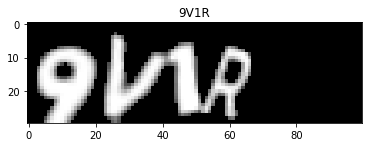

In [ ]:
# Look at random dataset exapmle
ind = np.random.randint(test_data['image'].shape[0])
test_img = test_data['image'][ind].numpy().squeeze()
test_label_inverse = test_data['label'][ind].numpy().squeeze()
test_label = ''.join([invers_dict[index] for index in test_label_inverse])
print(np.min(test_img), np.max(test_img))

plt.imshow(test_img, cmap='gray')
plt.title(test_label)
plt.show()

## Neural network

In [ ]:
NUM_CLASSES = len(labels_dict) + 1 # +1 for balnk label
balnk_index = len(labels_dict)

gru_hidden_size = 128
gru_num_layers = 3
cnn_output_height = 3
cnn_output_width = 10

input_units = [128, 256, 512]

class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, input_units[0], kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(input_units[0])
        self.conv2 = nn.Conv2d(input_units[0], input_units[0], kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(input_units[0])
        self.conv3 = nn.Conv2d(input_units[0], input_units[1], kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(input_units[1])
        self.conv4 = nn.Conv2d(input_units[1], input_units[1], kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(input_units[1])
        self.conv5 = nn.Conv2d(input_units[1], input_units[2], kernel_size=(3, 3), stride=(1,2))
        self.norm5 = nn.InstanceNorm2d(input_units[2])
        self.conv6 = nn.Conv2d(input_units[2], input_units[2], kernel_size=(3, 3), padding=1)
        self.norm6 = nn.InstanceNorm2d(input_units[2])
        self.reshaped_size = cnn_output_height * input_units[2]
        self.fc = nn.Linear(self.reshaped_size, NUM_CLASSES)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = self.conv5(out)
        out = self.norm5(out)
        out = F.leaky_relu(out)
        out = self.conv6(out)
        out = self.norm6(out)
        out = F.leaky_relu(out)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out = F.log_softmax(self.fc(out), dim=-1)
        return out

In [ ]:
# Check model parameters number and dimensions
model = CRNN()
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
model.eval()

4630949


CRNN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
  (norm2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
  (norm4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 2))
  (norm5): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm6): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (fc): Linear(in_feat

In [ ]:
# Check model ouput size
model_test_out = model(test_data['image'])
model_test_out.shape

torch.Size([128, 10, 37])

In [ ]:
# Check model ouput values
model_test_out[0][0]

tensor([-3.9981, -3.0718, -3.9891, -3.8091, -3.5063, -3.3581, -3.7333, -3.6898,
        -3.6253, -3.8986, -3.6185, -3.6484, -3.7638, -4.1390, -3.1690, -3.3238,
        -3.8732, -3.0923, -3.7054, -3.8434, -3.8592, -3.0209, -3.8030, -4.0827,
        -3.7651, -3.3721, -3.5591, -4.4424, -3.2520, -3.7560, -3.3910, -3.9542,
        -3.5551, -3.3069, -3.5677, -3.6513, -4.5338], grad_fn=<SelectBackward>)

In [ ]:
class Trainer():
    def __init__(self, dataloaders, model):
        self.dataloaders = dataloaders
        self.net = model.to(device)
        self.lr = LEARNING_RATE
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        
        self.lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=0.9)
        self.epoch_to_start = BEGIN_EPOCH
        self.max_num_epochs = EPOCHS
        self.pred = None # Net prediction
        self.batch = None # Batch for training
        self.loss = None # Loss at the batch
        self.is_training = False
        self.batch_id = 0
        self.epoch_id = 0
        self.checkpoint_dir = CHECKPOINT_DIR
        self.val_history = []
        self.train_history = []
        self.val_loss = []
        self.train_loss = []

        # Create checkpoint_dir if folders is not exist
        if os.path.exists(self.checkpoint_dir) is False:
            os.makedirs(self.checkpoint_dir)


    def _load_checkpoint(self):
        if os.path.exists(os.path.join(self.checkpoint_dir, 'tmp_ckpt.pt')):
            print('loading last checkpoint...')
            checkpoint = torch.load(os.path.join(self.checkpoint_dir, 'tmp_ckpt.pt'))
            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
            self.net.to(device)

            self.epoch_to_start = checkpoint['epoch_id'] + 1
            self.val_history = checkpoint['val_history']
            self.train_history = checkpoint['train_history']
            self.train_loss = checkpoint['train_loss']
            self.val_loss = checkpoint['val_loss']

            massage = 'Epoch to start = {}'
            print(massage.format(self.epoch_to_start))
            print()
        else:
            print('training from scratch...')

    def _save_checkpoint(self, ckpt_name):
        torch.save({
            'epoch_id': self.epoch_id,
            'val_history': self.val_history,
            'train_history': self.train_history,
            'val_loss': self.val_loss,
            'train_loss': self.train_loss,
            'model_state_dict': self.net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'lr_scheduler_state_dict': self.lr_scheduler.state_dict()
        }, os.path.join(self.checkpoint_dir, ckpt_name))

    def _update_lr_schedulers(self):
        self.lr_scheduler.step()
        
    def _collect_epoch_states(self):
        self.epoch_acc = np.mean(self.running_acc)
        self.epoch_loss = np.mean(self.running_loss)
        if self.is_training:
            self.train_history.append(self.epoch_acc)
            self.train_loss.append(self.epoch_loss)
        else:
            self.val_history.append(self.epoch_acc)
            self.val_loss.append(self.epoch_loss)
  
    def _update_checkpoints(self):
        clear_output()

        self._save_checkpoint(ckpt_name='tmp_ckpt.pt')
        message_epoch = 'Epoch {} / {}, Epoch_time {} sec'
        message_stat = 'Train_Loss {}, Train_Acc {}, Val_Loss {}, Val_Acc {}'
        epoch_time = round(time.time()-self.epoch_start_time)
        print(message_epoch.format(self.epoch_id, self.max_num_epochs-1, epoch_time))
        print(message_stat.format(self.train_loss[-1], self.train_history[-1], self.val_loss[-1], self.val_history[-1]))
        print()

        fig, ax = plt.subplots(1,2, figsize=(16, 6))
        ax[0].plot(self.val_loss, label='val_loss')
        ax[0].plot(np.argmin(np.array(self.val_loss)), min(self.val_loss), 'go')
        ax[0].text(np.argmin(np.array(self.val_loss))+0.02, min(self.val_loss)+0.001, str(round(min(self.val_loss),3)))
        ax[0].legend()
        ax[0].plot(self.train_loss, label='train_loss', color='orange')
        ax[0].set_title('Loss value')
        ax[0].legend()

        ax[1].plot(self.val_history, label='val_accuracy')
        ax[1].plot(np.argmax(np.array(self.val_history)), max(self.val_history), 'go')
        ax[1].text(np.argmax(np.array(self.val_history))+0.02, max(self.val_history)+0.001, str(round(max(self.val_history),3)))
        ax[1].legend()
        ax[1].plot(self.train_history, label='train_accuracy', color='orange')
        ax[1].set_title('Accuracy value')
        ax[1].legend()

        plt.show()

    def _save_current_checkpoint(self):
        self._save_checkpoint(ckpt_name='tmp_ckpt.pt')

    def _compute_acc(self):
        correct = 0
        total = 0
        target = self.batch['label']
        _, max_index = torch.max(self.pred, dim=2)
        for i in range(len(target)):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != balnk_index])
            if len(prediction) == len(target[i]) and torch.all(prediction.eq(target[i])):
                correct += 1
            total += 1
        self.running_acc.append(correct / total)

    def _clear_cache(self):
        self.running_acc = []
        self.running_loss = []

    def _forward_pass(self, batch):
        self.batch = batch
        img_in = batch['image'].to(device)
        self.pred = self.net(img_in)
        self.pred = self.pred.permute(1, 0, 2)
  
    def _backward_pass(self):
        target = self.batch['label'].to(device)
        input_lengths = torch.IntTensor(target.shape[0]).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in target])
        self.loss = criterion(self.pred, target, input_lengths, target_lengths)
        self.running_loss.append(self.loss.item())
        if self.is_training:
            self.loss.backward()

    # Model training function
    def train_model(self):
    
        self._load_checkpoint()

        for self.epoch_id in range(self.epoch_to_start, self.max_num_epochs):

            self.epoch_start_time = time.time()

            self._clear_cache()
            self.is_training = True
            self.net.train()

            for self.batch_id, batch in tqdm(enumerate(self.dataloaders['train'], 0)):
                self._forward_pass(batch)
                self.optimizer.zero_grad()
                self._backward_pass()
                self.optimizer.step()
                self._compute_acc()
            
            self._collect_epoch_states()
            self._update_lr_schedulers()

            print('Begin evaluation...')
            self._clear_cache()
            self.is_training = False
            self.net.eval()

            for self.batch_id, batch in tqdm(enumerate(self.dataloaders['val'], 0)):
                with torch.no_grad():
                    self._forward_pass(batch)
                    self._backward_pass()
                    self._compute_acc()

            self._collect_epoch_states()
            if self.epoch_id % 3 == 0 or self.epoch_id == self.max_num_epochs - 1:
                self._update_checkpoints()

In [ ]:
# Define parameters for model trainer
LEARNING_RATE = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CTCLoss(blank=balnk_index, reduction='mean', zero_infinity=True)
dataloaders = {'train': train_dataloader, 'val': test_dataloader}

model = CRNN()
BEGIN_EPOCH = 0
EPOCHS = 1000
CHECKPOINT_DIR = os.path.join(data_folder, 'model_6CONV_FLATTEN_3x10_GEN5_V2')

trainer = Trainer(dataloaders, model)

Epoch 999 / 999, Epoch_time 22 sec
Train_Loss 0.013966286568029318, Train_Acc 0.9841796875, Val_Loss 0.01731638825731352, Val_Acc 0.9763371394230769



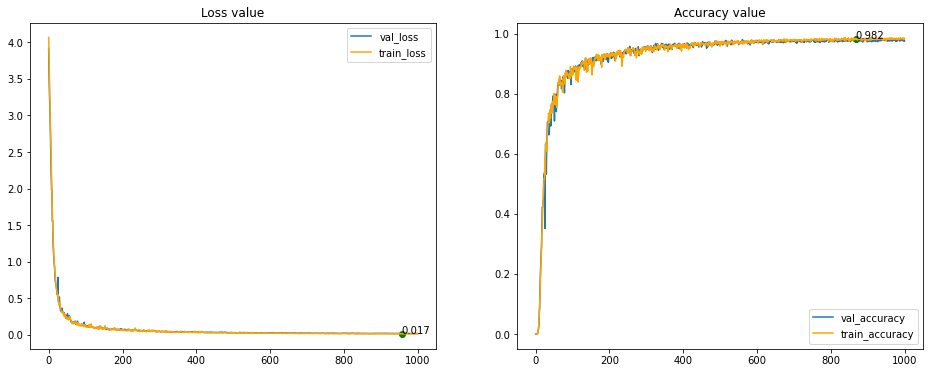

In [ ]:
# Train model
while True:
    try:
        trainer.train_model()
        break
    except Exception as e:
        print(e)
        continue

## Neural network testing

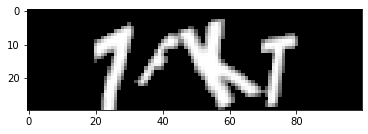

In [ ]:
# Prepare test captcha example
test_captcha = generate_captcha('7FKT', SIGMA, ALPHA, SHAPE, letter_shape, COEF_W, add_w)
plt.imshow(test_captcha, cmap='gray')
plt.show()

In [ ]:
# Load model from checkpoint
CHECKPOINT_DIR = os.path.join(data_folder, 'model_6CONV_FLATTEN_3x10_GEN5_V2')
model_to_eval = CRNN()
model_checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'tmp_ckpt.pt'))
model_to_eval.load_state_dict(model_checkpoint['model_state_dict'])
model_to_eval.eval()

CRNN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
  (norm2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
  (norm4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 2))
  (norm5): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm6): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (fc): Linear(in_feat

In [ ]:
# Get model prediction
test_input = torch.FloatTensor(np.expand_dims(test_captcha / 255, axis=0))
prediction = model_to_eval(test_input.unsqueeze(0))
pred_np = prediction.detach().cpu().numpy()

print(pred_np.shape)

(1, 10, 37)


In [ ]:
# Function for decoding indices from model prediction
def decode(pred_indices):
    pred_label = ''
    for ind in pred_indices:
        if ind != 36:
            pred_label += invers_dict[ind]
        else:
            pred_label += '-'

    return pred_label

In [ ]:
# Processing of model prediction
pred_indices = np.argmax(pred_np.squeeze(), axis=1)
pred_label = decode(pred_indices)
print(len(pred_label), pred_label)

10 -7F---KT--


In [ ]:
def procces_captcha(img, model):
    pattern = '[A-Z0-9]'
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bw_img = cv2.bitwise_not(gray_img)
    else:
        bw_img = img.copy()
    
    test_input = torch.FloatTensor(np.expand_dims(bw_img / 255, axis=0))
    prediction = model_to_eval(test_input.unsqueeze(0))
    pred_np = prediction.detach().cpu().numpy()

    pred_indices = np.argmax(pred_np.squeeze(), axis=1)
    pred_label = decode(pred_indices)

    filterd_text = re.findall(pattern, pred_label)
    if len(filterd_text) == 0:
        text_gray = 'not recognized'
    else:
        text_gray = ''.join(filterd_text)

    plt.imshow(bw_img, cmap='gray')
    plt.title(text_gray)
    plt.show()

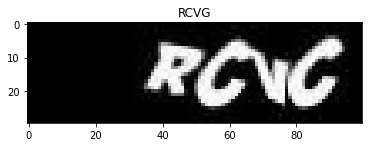

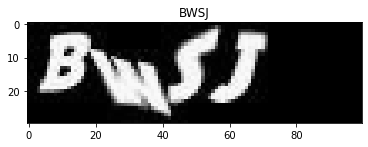

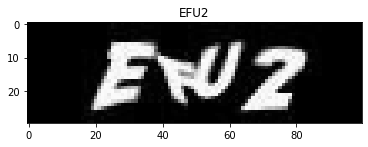

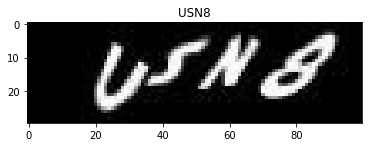

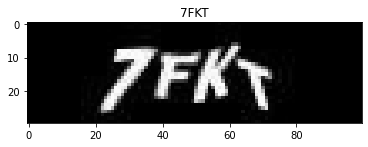

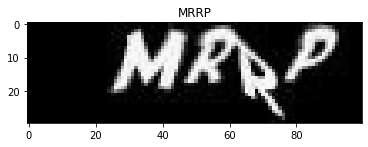

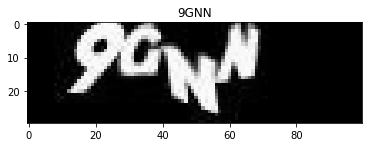

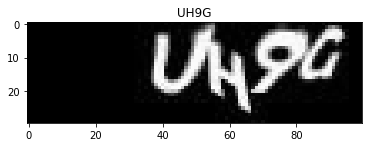

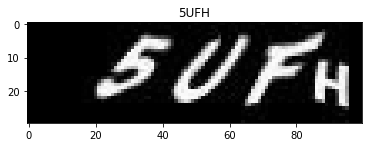

In [ ]:
# Test model on real captchas
images_folder = os.path.join(data_folder, 'images')
for filename in os.listdir(images_folder):
    image_path = os.path.join(images_folder, filename)
    img = cv2.imread(image_path)
    procces_captcha(img, model_to_eval)
    print()

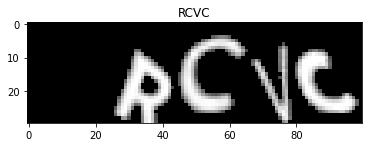

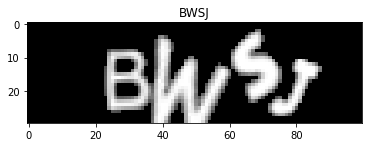

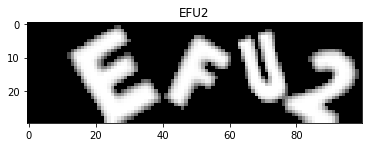

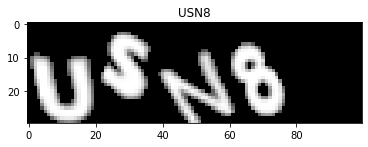

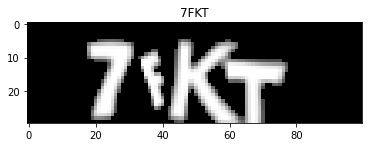

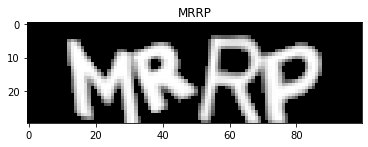

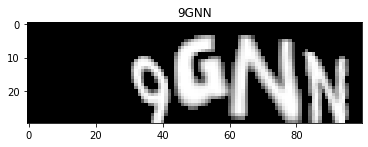

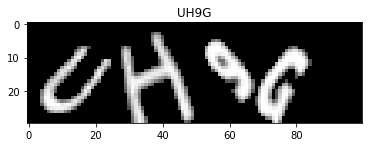

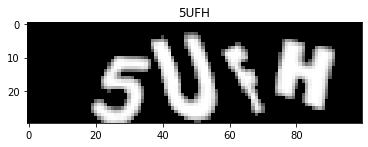

In [ ]:
# Test model on fake captchas
captcha_labels = ['RCVC', 'BWSJ', 'EFU2', 'USN8', '7FKT', 'MRRP', '9GNN', 'UH9G', '5UFH']
for label in captcha_labels:
    test_captcha = generate_captcha(label, SIGMA, ALPHA, SHAPE, letter_shape, COEF_W, add_w)
    procces_captcha(test_captcha, model_to_eval)
    print()

## Save model to .onnx

In [ ]:
import torch.onnx
import onnxruntime

In [ ]:
# Load model
CHECKPOINT_DIR = os.path.join(data_folder, 'model_6CONV_FLATTEN_3x10_GEN5_V2')
model_to_eval = CRNN()
model_checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'tmp_ckpt.pt'))
model_to_eval.load_state_dict(model_checkpoint['model_state_dict'])
model_to_eval.eval()

CRNN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
  (norm2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
  (norm4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 2))
  (norm5): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm6): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (fc): Linear(in_fe

In [ ]:
# Input to the model
batch_size = 1
x = torch.randn(batch_size, 1, 30, 100, requires_grad=True)
torch_out = model_to_eval(x)
model_path = os.path.join(data_folder, 'model.onnx')

# Export the model
torch.onnx.export(model_to_eval,             # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  model_path,                # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

Test pytorch model on real captchas

In [ ]:
def decode(pred_indices):
    pred_label = ''
    for ind in pred_indices:
        if ind != 36:
            pred_label += invers_dict[ind]
        else:
            pred_label += '-'

    return pred_label


def procces_captcha(img, model):
    pattern = '[A-Z0-9]'
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bw_img = cv2.bitwise_not(gray_img)
    else:
        bw_img = img.copy()
    

    test_input = torch.FloatTensor(np.expand_dims(bw_img / 255, axis=0))
    prediction = model_to_eval(test_input.unsqueeze(0))
    pred_np = prediction.detach().cpu().numpy()

    pred_indices = np.argmax(pred_np.squeeze(), axis=1)
    pred_label = decode(pred_indices)

    filterd_text = re.findall(pattern, pred_label)
    if len(filterd_text) == 0:
        text_gray = 'not recognized'
    else:
        text_gray = ''.join(filterd_text)

    plt.imshow(bw_img, cmap='gray')
    plt.title(text_gray)
    plt.show()

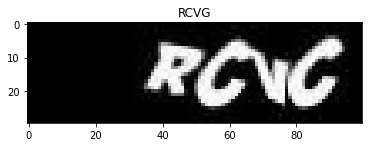

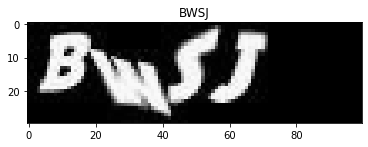

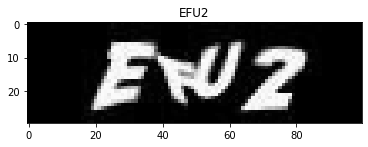

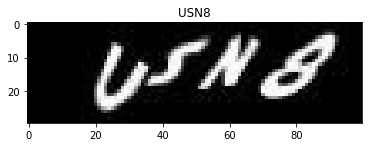

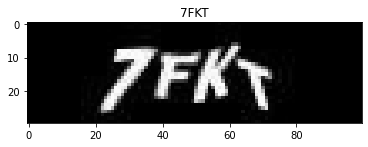

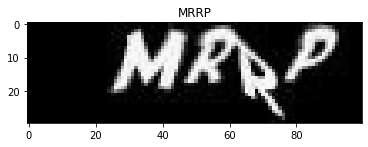

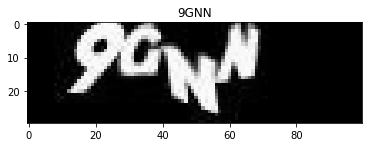

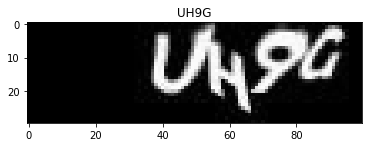

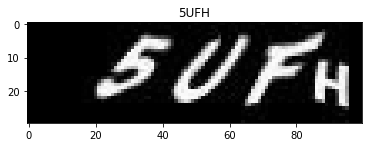

In [ ]:
images_folder = os.path.join(data_folder, 'images')
for filename in os.listdir(images_folder):
    image_path = os.path.join(images_folder, filename)
    img = cv2.imread(image_path)
    procces_captcha(img, model_to_eval)
    print()

Test .onnx model on real captchas

In [ ]:
def decode(pred_indices):
    pred_label = ''
    for ind in pred_indices:
        if ind != 36:
            pred_label += invers_dict[ind]
        else:
            pred_label += '-'

    return pred_label


def procces_captcha_onnx(img, onnx_model):
    pattern = '[A-Z0-9]'
    h, w = img.shape[:2]
    
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bw_img = cv2.bitwise_not(gray_img)
    else:
        bw_img = img.copy()
        
    img_to_onnx = bw_img.reshape(1,1,h,w).astype(np.float32) / 255
    
    ort_inputs = {onnx_model.get_inputs()[0].name: img_to_onnx}
    ort_outs = onnx_model.run(None, ort_inputs)
    
    pred_np = ort_outs[0]

    pred_indices = np.argmax(pred_np.squeeze(), axis=1)
    pred_label = decode(pred_indices)

    filterd_text = re.findall(pattern, pred_label)
    if len(filterd_text) == 0:
        text_gray = 'not recognized'
    else:
        text_gray = ''.join(filterd_text)

    plt.imshow(bw_img, cmap='gray')
    plt.title(text_gray)
    plt.show()

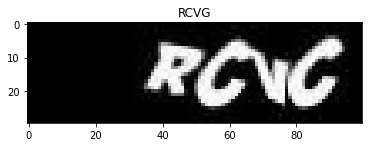

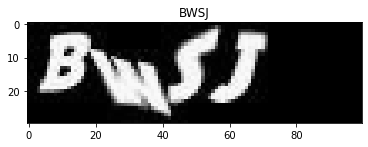

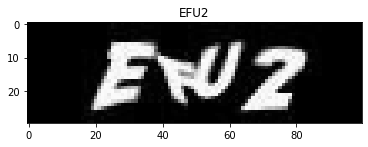

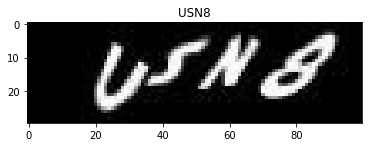

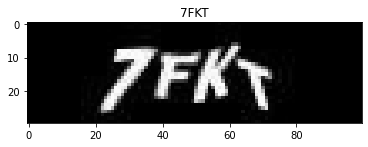

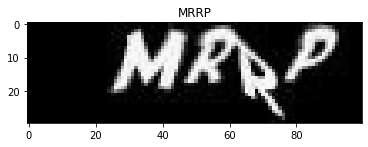

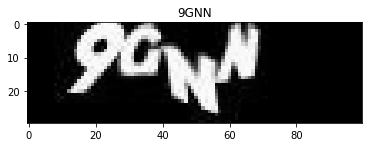

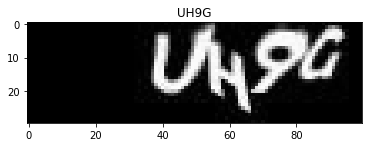

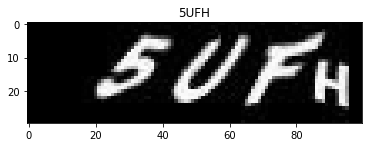

In [ ]:
onnx_model = onnxruntime.InferenceSession(model_path)

images_folder = os.path.join(data_folder, 'images')
for filename in os.listdir(images_folder):
    image_path = os.path.join(images_folder, filename)
    img = cv2.imread(image_path)
    procces_captcha_onnx(img, onnx_model)
    print()

## Solver class test

In [ ]:
import os
import re
import toml
import pathlib
import time
import string
import base64
from decimal import Decimal
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.remote.webelement import WebElement

import onnxruntime
import cv2
import numpy as np

from typing import List, Dict
import matplotlib.pyplot as plt

In [ ]:
# All necessary links
ali_links = 'E://pyProject/MinerKiller/minerkiller/ali_links.toml'
login = 'neuronlearning322@gmail.com'
password = 'bn322ui8f'
driver_path = 'E://chromedriver/chromedriver.exe'
aliexpress_shop_link = "https://citilink.aliexpress.ru/"

data_folder = 'E://pyProject/MinerKiller/captcha_base/captcha_solver/'
model_path = os.path.join(data_folder, 'model.onnx')

In [ ]:
class CaptchaSolver:
    def __init__(self, driver: webdriver, model_path: str, selectors: Dict):
        self.driver = driver
        self.model = onnxruntime.InferenceSession(model_path)
        self.blank_index = 36
        self.img_height = 30
        self.img_wigth = 100
        with open(ali_links) as f:
            self.selectors = toml.load(f)
        alphabet = string.ascii_uppercase + '0123456789'
        self.pred_dict = {value: key for value, key in enumerate(alphabet)}
        
        
    def _send_text(self, textbox_selector: str, text: str) -> None:
        element = self.driver.find_element_by_css_selector(textbox_selector)
        element.clear()
        element.send_keys(text)
        
    def _push_button(self, button_selector: str) -> None:
        button = self.driver.find_element_by_css_selector(button_selector)
        button.click()
        
    def _read_captcha(self, captcha_selector: str) -> np.ndarray:
        img_element = self.driver.find_element_by_css_selector(captcha_selector)
        img_data = img_element.find_element_by_css_selector('img').get_attribute('src')
        # Source data example - 'data:image/jpg;base64,/9j/4AAQSk...'
        img_base64 = img_data[img_data.find(',')+1:]
        img_bytes = base64.b64decode(img_base64)
        img_arr = np.frombuffer(img_bytes, dtype=np.uint8)
        img = cv2.imdecode(img_arr, flags=cv2.IMREAD_COLOR)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img = cv2.bitwise_not(gray_img)
        
        return gray_img
        
    def _decode(self, pred_indices: np.ndarray) -> str:
        pred_label = ''
        for ind in pred_indices:
            if ind != self.blank_index:
                pred_label += self.pred_dict[ind]
            else:
                pred_label += '-'

        return pred_label
    
    def _reshape_img(self, img: np.ndarray) -> np.ndarray:
        h, w = img.shape[:2]
        if h != self.img_height or w != self.img_wigth:
            img = cv2.resize(img,  (w, h))
        return img
    
    def _procces_captcha_onnx(self, img: np.ndarray) -> str:
        pattern = '[A-Z0-9]'  
        plt.imshow(img, cmap='gray')
        plt.show()
        img_to_onnx = img.reshape(1,1,self.img_height,self.img_wigth).astype(np.float32) / 255

        inputs = {self.model.get_inputs()[0].name: img_to_onnx}
        outs = self.model.run(None, inputs)

        pred_np = outs[0]

        pred_indices = np.argmax(pred_np.squeeze(), axis=1)
        pred_label = self._decode(pred_indices)

        filterd_text = re.findall(pattern, pred_label)
        if len(filterd_text) == 0:
            captcha_text = '6666'
        else:
            captcha_text = ''.join(filterd_text)
            
        print(captcha_text)
            
        return captcha_text
            
    def solve_captcha(self) -> None:
        
        img = self._read_captcha(self.selectors['CAPTCHA_IMAGE'])
        img = self._reshape_img(img)
        text = self._procces_captcha_onnx(img)
        
        self._send_text(self.selectors['CAPTCHA_TEXTBOX'], text)
        self._push_button(self.selectors['CAPTCHA_BUTTON'])

In [ ]:
# Start webdriver
options = webdriver.ChromeOptions()
options.add_experimental_option('excludeSwitches', ['enable-logging'])
driver = webdriver.Chrome(executable_path=driver_path, options=options)

In [ ]:
# Go to aliexpress
driver.get(aliexpress_shop_link)

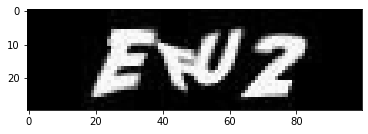

EFU2


In [ ]:
# Solve captcha
solver = CaptchaSolver(driver, model_path, 1)
solver.solve_captcha()